### Modeling Using 7D Data

In [104]:
# Standard library imports
import os
import psutil
from datetime import datetime

# Numerical and data manipulation libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    auc, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA

# Deep learning libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report

# check memory usage
memory_info = psutil.Process().memory_info()
print(f"Memory Usage: {memory_info.rss / (1024 ** 2):.2f} MB")  

pd.set_option('display.float_format', lambda x: '%.3f' % x)

Memory Usage: 2100.05 MB


In [9]:
import random

In [3]:
# Load the data
file_path = "0901to0907_agg0.csv"

df = pd.read_csv(file_path)

display(df.head(3))
print(df.info())

,customer_key,node_id,outage,interaction_volume,custom_msg_count,cbuser_count,ccmuser_count,coxcnsuser_count,coxconnectuser_count,digitalassistbotuser_count,...,syntheticuser_count_30min_sum,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,time_period_midnight_to_noon_UTC,time_period_noon_to_midnight_UTC
0,148091,1_3WKX2,0,1,0,0,1,0,0,0,...,0,False,False,False,False,False,False,True,True,False
1,118037734,541_7JLU1,0,3,0,0,3,0,0,0,...,0,False,False,False,False,False,False,True,True,False
2,118042036,541_7JDR2,0,1,0,0,1,0,0,0,...,0,False,False,False,False,False,False,True,True,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7021811 entries, 0 to 7021810
Data columns (total 46 columns):
 #   Column                                Dtype 
---  ------                                ----- 
 0   customer_key                          int64 
 1   node_id                               object
 2   outage                                int64 
 3   interaction_volume                    int64 
 4   custom_msg_count                      int64 
 5   cbuser_count                          int64 
 6   ccmuser_count                         int64 
 7   coxcnsuser_count                      int64 
 8   coxconnectuser_count                  int64 
 9   digitalassistbotuser_count            int64 
 10  fsmobilityuser_count                  int64 
 11  ibilluser_count                       int64 
 12  icesdtwsuser_count                    int64 
 13  icomsuser_count                       int64 
 14  IAE_count                             int64 
 15  ivravayauser_count              

In [5]:
# Define response & features
exclude_cols = ['customer_key','node_id']
feature_cols = [col for col in df.columns if col not in exclude_cols]

df_clean = df[feature_cols]

In [7]:
train_data, test_data = train_test_split(df_clean, test_size=0.2, random_state=1)

In [23]:
scaler = StandardScaler()
X_train = train_data.drop(columns=["outage"])
X_train_scaled = scaler.fit_transform(X_train)
y_train = train_data["outage"]

X_test = test_data.drop(columns=["outage"])
X_test_scaled = scaler.transform(X_test) 
y_test = test_data["outage"]

In [100]:
X=X_train_scaled
y=np.array(train_data["outage"])

#### Logistic Regression Model

In [11]:
# Logistic Regression
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Modeling
model = LogisticRegression()

# 5-Fold CV
cv_scores = cross_val_score(model, X_scaled, y_train, cv = 5, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean AUC Score: {cv_scores.mean()}")

y_pred_cv = cross_val_predict(model, X_scaled, y_train, cv=3, method='predict')
y_prob_cv = cross_val_predict(model, X_scaled, y_train, cv=3, method='predict_proba')[:, 1]

print("Classification Report (Cross-Validation):\n", classification_report(y_train, y_pred_cv))
print("ROC AUC Score (Cross-Validation):", roc_auc_score(y_train, y_prob_cv))

Cross-Validation AUC Scores: [0.94439262 0.94491888 0.94430077 0.94471464 0.94407655]
Mean AUC Score: 0.9444806901147558
Classification Report (Cross-Validation):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99   5283124
           1       0.95      0.65      0.77    334324

    accuracy                           0.98   5617448
   macro avg       0.96      0.82      0.88   5617448
weighted avg       0.98      0.98      0.98   5617448

ROC AUC Score (Cross-Validation): 0.9444651737608404


TN: 5271224 FP: 11900 FN: 117055 TP: 217269


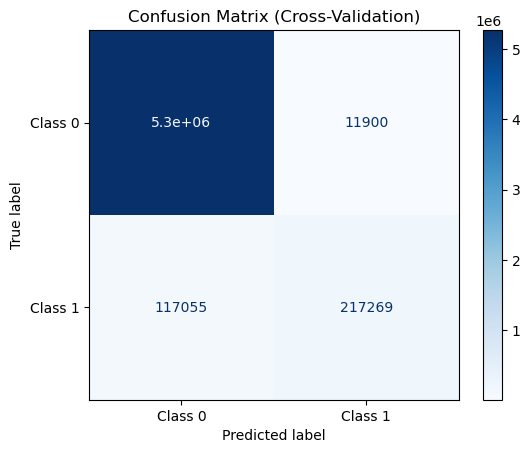

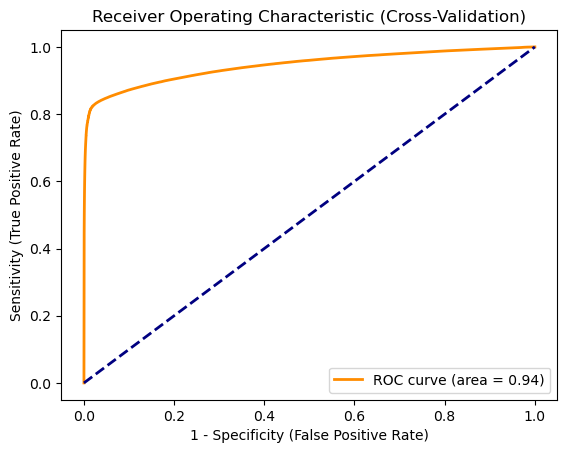

In [13]:
# Confusion Matrix
conf_matrix_cv = confusion_matrix(y_train, y_pred_cv)
tn, fp, fn, tp = conf_matrix_cv.ravel()
print('TN:', tn, 'FP:', fp, 'FN:', fn, 'TP:', tp)

# Display Confusion Matrix
ConfusionMatrixDisplay(conf_matrix_cv, display_labels=["Class 0", "Class 1"]).plot(cmap="Blues")
plt.title("Confusion Matrix (Cross-Validation)")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, y_prob_cv)
roc_auc_cv = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cv)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic (Cross-Validation)')
plt.legend(loc="lower right")
plt.show()

In [19]:
# Feature Importance
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
coefficients_list = []

for train_idx, test_idx in cv.split(X_train_scaled, y):
    X_train, X_test = X_train_scaled[train_idx], X_train_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model.fit(X_train, y_train)
    coefficients_list.append(model.coef_[0])

Feature: work_order_count, Importance: 10.334471654100783
Feature: ccmuser_count_30min_sum, Importance: 3.059912449853376
Feature: interaction_volume, Importance: 1.068909094067014
Feature: ccmuser_count, Importance: 0.3651730273055438
Feature: syntheticuser_count_30min_sum, Importance: 0.1965701224269778
Feature: ivravayauser_count_30min_sum, Importance: 0.19474314934833759
Feature: weekday_2, Importance: 0.18315878895971474
Feature: weekday_1, Importance: 0.1762182886557974
Feature: fsmobilityuser_count_30min_sum, Importance: 0.15912846738707162
Feature: lob_R, Importance: 0.15673731418235393
Feature: cbuser_count_30min_sum, Importance: 0.1489515191849874
Feature: solcenuser_count_30min_sum, Importance: 0.13370156328665542
Feature: icomsuser_count_30min_sum, Importance: 0.11603984171178157
Feature: icesdtwsuser_count_30min_sum, Importance: 0.11368541505896707
Feature: solcenuser_count, Importance: 0.10293267447770754
Feature: ivravayauser_count, Importance: 0.09869598964316025
Featur

C:\Users\andre\AppData\Local\Temp\ipykernel_24072\2264143568.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


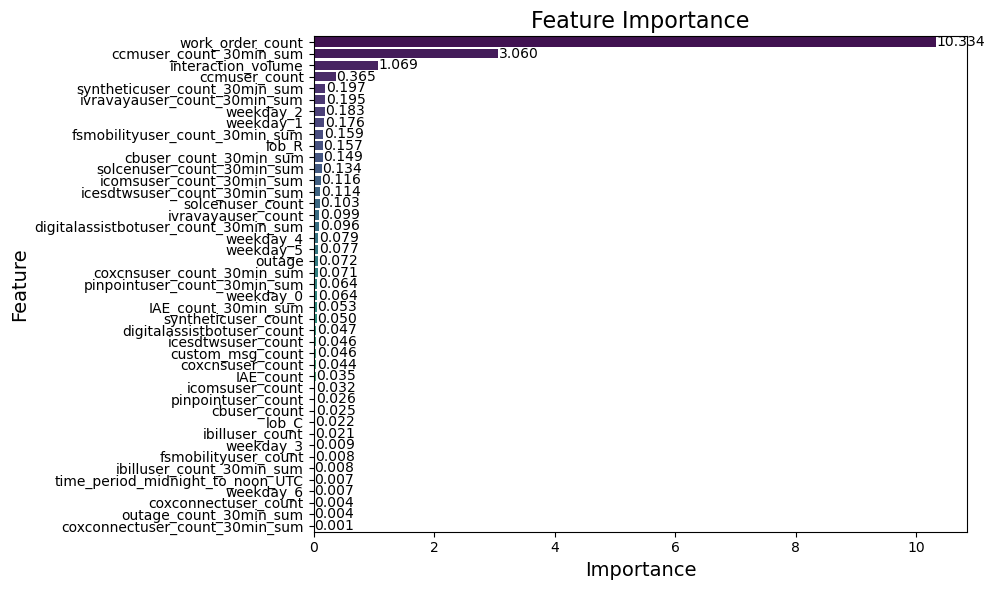

In [90]:
avg_coefficients = np.mean(coefficients_list, axis=0)
feature_importance = np.abs(avg_coefficients)
feature_names = train_data.columns

importance = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)
for feature, importance_value in importance:
    print(f"Feature: {feature}, Importance: {importance_value}")



importance_df = pd.DataFrame(importance, columns=['Feature', 'Importance']).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=importance_df,
    palette="viridis"
)

for index, value in enumerate(importance_df["Importance"]):
    plt.text(value + 0.01, index, f"{value:.3f}", va='center')  

plt.title("Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)

plt.tight_layout()
plt.show()

Best Threshold with Youden's J: 0.046
Best Threshold with F1 Score: 0.114


C:\Users\andre\AppData\Local\Temp\ipykernel_24072\3981565898.py:58: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\andre\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


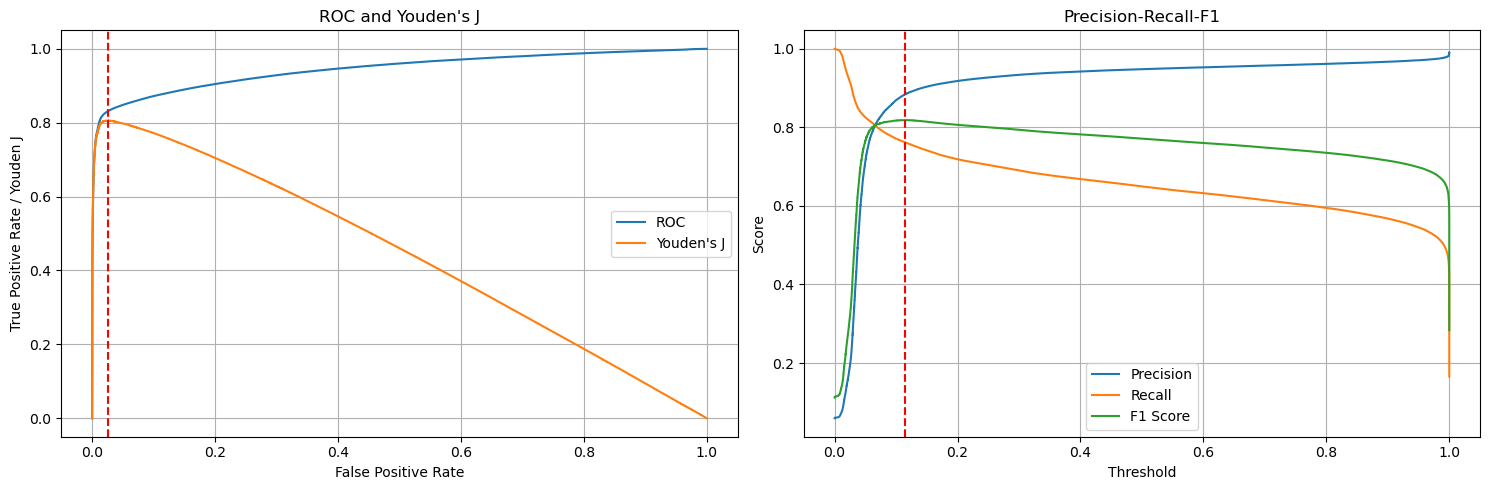


Metrics with Youden's J threshold:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98   5283124
           1       0.67      0.83      0.74    334324

    accuracy                           0.97   5617448
   macro avg       0.83      0.90      0.86   5617448
weighted avg       0.97      0.97      0.97   5617448


Metrics with F1 score threshold:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   5283124
           1       0.88      0.76      0.82    334324

    accuracy                           0.98   5617448
   macro avg       0.93      0.88      0.90   5617448
weighted avg       0.98      0.98      0.98   5617448



In [106]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import precision_recall_curve, roc_curve, classification_report
# from sklearn.model_selection import cross_val_predict
# from sklearn.linear_model import LogisticRegression
# import numpy as np
# import matplotlib.pyplot as plt

# Create pipeline without PCA
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

# Get probability predictions
y_prob_cv = cross_val_predict(pipe, X, y, cv=5, method='predict_proba')
y_prob_cv = y_prob_cv[:, 1]  # Probabilities for positive class

# Calculate metrics for Youden's J
fpr, tpr, thresholds_roc = roc_curve(y, y_prob_cv)
youden_j = tpr - fpr
best_j_idx = np.argmax(youden_j)
best_threshold_j = thresholds_roc[best_j_idx]

# Calculate metrics for F1 score
precision, recall, thresholds_pr = precision_recall_curve(y, y_prob_cv)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_f1_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds_pr[best_f1_idx]

print(f"Best Threshold with Youden's J: {best_threshold_j:.3f}")
print(f"Best Threshold with F1 Score: {best_threshold_f1:.3f}")

# Plot both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot ROC and Youden's J
ax1.plot(fpr, tpr, label='ROC')
ax1.plot(fpr, youden_j, label="Youden's J")
ax1.axvline(x=fpr[best_j_idx], color='r', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate / Youden J')
ax1.set_title("ROC and Youden's J")
ax1.legend()
ax1.grid(True)

# Plot Precision-Recall-F1
ax2.plot(thresholds_pr, precision[:-1], label='Precision')
ax2.plot(thresholds_pr, recall[:-1], label='Recall')
ax2.plot(thresholds_pr, f1_scores, label='F1 Score')
ax2.axvline(x=best_threshold_f1, color='r', linestyle='--')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Precision-Recall-F1')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print performance metrics for both thresholds
print("\nMetrics with Youden's J threshold:")
y_pred_j = (y_prob_cv >= best_threshold_j).astype(int)
print(classification_report(y, y_pred_j))

print("\nMetrics with F1 score threshold:")
y_pred_f1 = (y_prob_cv >= best_threshold_f1).astype(int)
print(classification_report(y, y_pred_f1))

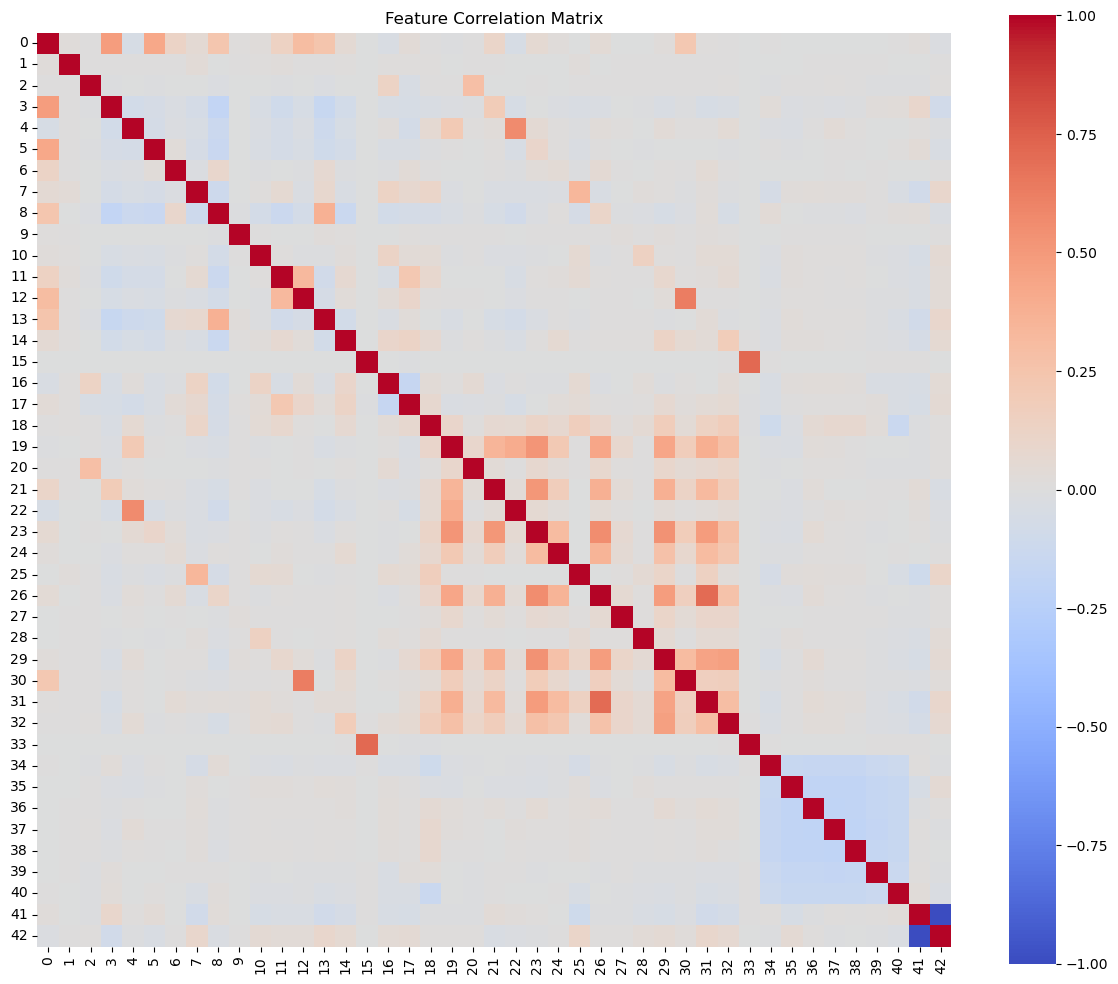

In [112]:
# PCA for logstic regression
# Examing Multicollinearity
X_df = pd.DataFrame(X)
correlation_matrix = X_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            cmap='coolwarm',     
            center=0,            
            annot=False,         
            square=True,         
            vmin=-1,            
            vmax=1)             

plt.title('Feature Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()  
plt.show()

In [114]:
# from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# # Data standardization 
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# PCA dimensionality reduction
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Check explained variance ratio of each component
print("Explained variance ratio of each component:")
print(pca.explained_variance_ratio_)
print("\nCumulative explained variance ratio:", sum(pca.explained_variance_ratio_))
print("\nNumber of components before reduction:", X.shape[1])
print("\nNumber of components after reduction:", X_pca.shape[1])

Explained variance ratio of each component:
[0.09213644 0.05222043 0.04708845 0.04224642 0.03995105 0.03750735
 0.0344553  0.03350019 0.032183   0.02834754 0.02783632 0.02768237
 0.02745304 0.02690167 0.02656958 0.0260482  0.02523348 0.02511025
 0.02434644 0.02360458 0.02309594 0.02287286 0.02226859 0.02102642
 0.01964587 0.01933613 0.01912055 0.01781761 0.01720065 0.01598767
 0.01523872 0.01424662 0.01354432 0.01270827]

Cumulative explained variance ratio: 0.9545323186453926

Number of components before reduction: 43

Number of components after reduction: 34


In [116]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Create a pipeline that combines PCA and logistic regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('lr', LogisticRegression())
])

# Perform 5-fold cross validation
cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')

# Print results
print("Cross-validation scores:", cv_scores)
print("Average accuracy: {:.3f} (+/- {:.3f})".format(cv_scores.mean(), cv_scores.std() * 2))

# Optional: Compare with original logistic regression without PCA
cv_scores_original = cross_val_score(LogisticRegression(), X, y, cv=5, scoring='accuracy')
print("\nOriginal model without PCA:")
print("Cross-validation scores:", cv_scores_original)
print("Average accuracy: {:.3f} (+/- {:.3f})".format(cv_scores_original.mean(), cv_scores_original.std() * 2))

Cross-validation scores: [0.96106863 0.96088261 0.95981273 0.96064225 0.96071791]
Average accuracy: 0.961 (+/- 0.001)

Original model without PCA:
Cross-validation scores: [0.97712841 0.97688987 0.97707946 0.97704472 0.97701802]
Average accuracy: 0.977 (+/- 0.000)


In [118]:
### Logistic Regression Model Performance

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on training data
X_test_scaled = scaler.transform(X_test)       # Transform on test data

# Create and train the logistic regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_prob_logreg = logreg.predict(X_test_scaled)
y_pred_logreg = (y_pred_prob_logreg > 0.5).astype(int) 

#### Neural Network Model

In [120]:
# Ensure X_train and X_test are float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Ensure y_train and y_test are integers (if classification)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [122]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\andre\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [124]:
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))

Epoch 1/10
14629/14629 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.9785 - loss: 0.0863 - val_accuracy: 0.9847 - val_loss: 0.0640
Epoch 2/10
14629/14629 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9847 - loss: 0.0640 - val_accuracy: 0.9849 - val_loss: 0.0635
Epoch 3/10
14629/14629 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9850 - loss: 0.0626 - val_accuracy: 0.9850 - val_loss: 0.0625
Epoch 4/10
14629/14629 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9851 - loss: 0.0626 - val_accuracy: 0.9853 - val_loss: 0.0624
Epoch 5/10
14629/14629 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.9853 - loss: 0.0616 - val_accuracy: 0.9852 - val_loss: 0.0622
Epoch 6/10
14629/14629 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9854 - loss: 0.0618 - val_accuracy: 0.9853 - val_loss: 0.0620
Epoch 7/10
14629/14629 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9854 - loss: 0.0614 - val_accuracy: 0.9852 - val_loss: 0.0620
Epoch 8/10
14629/14629 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 

In [126]:
y_pred_prob_nn = model.predict(X_test)
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)  # Convert to 0 or 1 based on threshold

58516/58516 ━━━━━━━━━━━━━━━━━━━━ 52s 882us/step


#### Model Performance Comparison

In [128]:
# Calculate metrics for logistic regression
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Calculate metrics for neural network
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_prob_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Print the comparison
print("Performance Comparison:")
print(f"Logistic Regression -> Accuracy: {accuracy_logreg:.4f}, Precision: {precision_logreg:.4f}, Recall: {recall_logreg:.4f}, AUC: {roc_auc_logreg:.4f}")
print(f"Neural Network      -> Accuracy: {accuracy_nn:.4f}, Precision: {precision_nn:.4f}, Recall: {recall_nn:.4f}, AUC: {roc_auc_nn:.4f}")

Performance Comparison:
Logistic Regression -> Accuracy: 0.9770, Precision: 0.9478, Recall: 0.6485, AUC: 0.8231
Neural Network      -> Accuracy: 0.9853, Precision: 0.9183, Recall: 0.8273, AUC: 0.9582


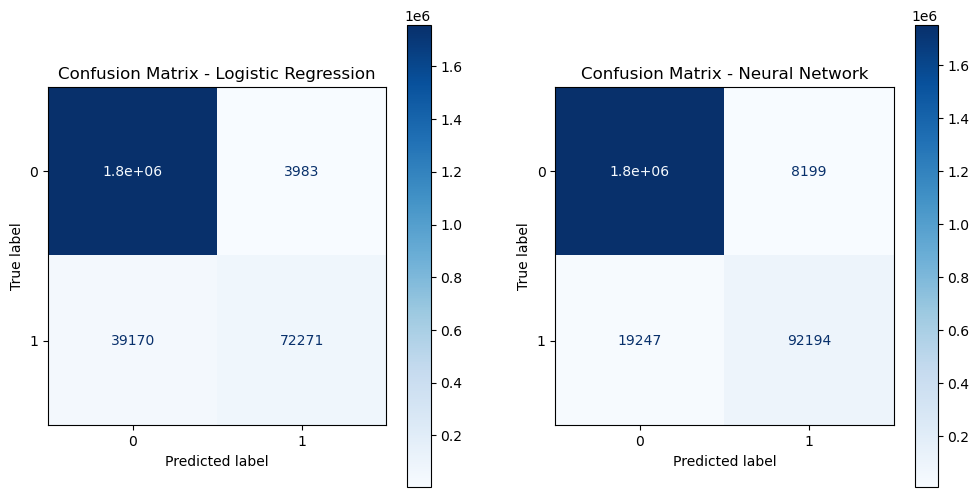

In [130]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_logreg, display_labels=[0, 1]).plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title("Confusion Matrix - Logistic Regression")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_nn, display_labels=[0, 1]).plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title("Confusion Matrix - Neural Network")
plt.show()

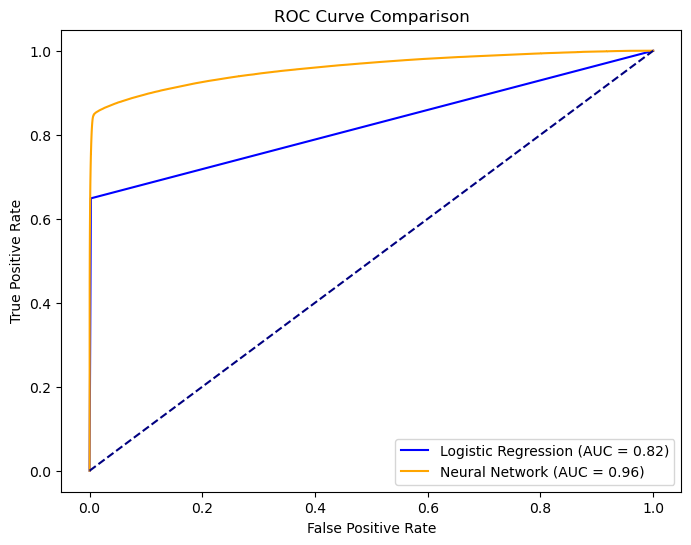

In [132]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, color='blue', label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_nn, tpr_nn, color='orange', label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()